In [2]:
import torch
from torch import nn
import d2l.torch as d2l

In [3]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels), nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    )

In [8]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, grow_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(conv_block(in_channels + grow_rate * i, grow_rate))
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [10]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
in_channels, grow_rate = 64, 32
num_convs_in_denese_blk = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_denese_blk):
    blks.append(DenseBlock(num_convs, in_channels, grow_rate))
    in_channels += num_convs * grow_rate

    if i != len(num_convs_in_denese_blk) - 1:
        blks.append(transition_block(in_channels, in_channels // 2))
        in_channels = in_channels // 2

net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(in_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(in_channels, 10)
)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

loss 0.160, train acc 0.941, test acc 0.901
1766.3 examples/sec on cuda:0


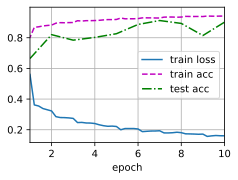

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())